## **Pricing Optimisation**

## Part 1
The goal of part 1 is to model passenger and driver behaviour, especially regarding price sensitivity. Feel free to explore the data and using the labelled datasets, train and evaluate models to predict:

- Probability that a passenger will accept a quote
- Probability that a driver will accept an offer
  
We are looking at your ability to build/evaluate ML models and implementation of best practices but don’t spend too much time on performance or fine-tuning.
As a bonus, can you perform a sensitivity analysis to see how the probability of acceptance changes with varying price?

**Hint:** For handling geospatial data you may want to consider using grid (like h3 for example)

In [1]:
import pandas as pd
import numpy as np

import shap
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

import warnings
warnings.filterwarnings('ignore') 

sns.set_style("whitegrid")

In [2]:
quote_conversion_df = pd.read_parquet('./Datasets/DSMarketplaceTHA-QuoteConversion.parquet')
driver_acceptance_df = pd.read_parquet('./Datasets/DSMarketplaceTHA-DriverAcceptance.parquet')
test_quotes_df = pd.read_parquet('./Datasets/DSMarketplaceTHA-TestQuotes.parquet')

In [3]:
quote_conversion_df.head()

datetime  price  eta  route_distance  route_duration  \
2  2023-09-21 20:09:01.670    610  3.0             385             137   
3  2023-09-22 00:42:36.531    987  7.0            1622             294   
4  2023-10-01 17:07:22.592   1206  3.0            2005             581   
12 2023-09-12 22:25:06.443   2106  2.0            4885             964   
13 2023-09-12 23:38:25.511   2036  2.0            4885             848   

    source_latitude  source_longitude  destination_latitude  \
2         51.515146         -0.155957             51.513137   
3         51.516459         -0.132796             51.521680   
4         51.506054         -0.145319             51.516605   
12        51.504872         -0.127229             51.516187   
13        51.504789         -0.126935             51.516120   

    destination_longitude  converted  
2               -0.153143          0  
3               -0.142685          0  
4               -0.136498          0  
12              -0.067590          0  
13              -0.067344          0

In [4]:
driver_acceptance_df

datetime                         bookingid  \
0      2023-09-10 01:01:12.741000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
1      2023-09-10 01:01:28.064000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
2      2023-09-10 01:01:33.302000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
3      2023-09-10 01:02:04.143000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
4      2023-09-10 01:02:38.354000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
...                                 ...                               ...   
783220 2023-10-01 23:54:00.693000+00:00  53f5410e6fa284f4aec308a0d62f2c5e   
783221 2023-10-01 23:53:58.162000+00:00  deeac9425b46bdd86daadcdad0f5b21c   
783222 2023-10-01 23:55:47.552000+00:00  7b2fbabb1ebd05d368b8f2092e1467b7   
783223 2023-10-01 23:56:11.741000+00:00  ae1f5d71d77863d807ac4ae168dd3ca5   
783224 2023-10-01 23:56:18.839000+00:00  ae1f5d71d77863d807ac4ae168dd3ca5   

                                driverid         status  pickup_duration  \
0       43d3ebe78c04aef7bafe5cf26fa53563  DRIVER_REJECT              107   
1       a25fb994702b734b157d6de98c87881d  DRIVER_REJECT              142   
2       e2ef11b3360b0f59fa454bdf18e9376c  DRIVER_REJECT              137   
3       2873bd03f370d0461fe86e4b20b4d7f0  DRIVER_REJECT              204   
4       b9ee06b6118449ed31d7d1e105d4e538  DRIVER_REJECT              303   
...                                  ...            ...              ...   
783220  97a5ecf4c56f56b019ec38bf50f82d72  DRIVER_ACCEPT              175   
783221  43a4bd7238be940339d5cff38f148dd7  DRIVER_ACCEPT                8   
783222  126825b8d4d0c6b0b88488287b46f190  DRIVER_ACCEPT              246   
783223  ef8233e58babe46fb4408b53a3c1a04b  DRIVER_REJECT              249   
783224  a016a43d00770218f3afcb2ad4293340  DRIVER_REJECT              928   

        pickup_distance  price  route_distance  route_duration  \
0                   375  23.41            4476             676   
1                   522  23.41            4476             676   
2                   569  23.41            4476             676   
3                   914  23.41            4476             676   
4                  1925  23.41            4476             676   
...                 ...    ...             ...             ...   
783220             1002   8.70             613             140   
783221               35  30.96            7969            1120   
783222             1399  13.63            2162             388   
783223             1883  19.00            3554             423   
783224             8978  19.00            3554             423   

        source_latitude  source_longitude  destination_latitude  \
0             51.509333         -0.146257             51.490041   
1             51.509333         -0.146257             51.490041   
2             51.509333         -0.146257             51.490041   
3             51.509333         -0.146257             51.490041   
4             51.509333         -0.146257             51.490041   
...                 ...               ...                   ...   
783220        51.519211         -0.169134             51.516361   
783221        51.515247         -0.162968             51.549485   
783222        51.497833         -0.135431             51.510132   
783223        51.438427         -0.244941             51.455222   
783224        51.438427         -0.244941             51.455222   

        destination_longitude  
0                   -0.122111  
1                   -0.122111  
2                   -0.122111  
3                   -0.122111  
4                   -0.122111  
...                       ...  
783220              -0.163930  
783221              -0.243898  
783222              -0.141401  
783223              -0.228697  
783224              -0.228697  

[783172 rows x 13 columns]

#### Data Preparation

##### Convert Price

In [5]:
quote_conversion_df.price.describe()

count    869138.000000
mean       2333.473011
std        1211.589487
min         472.000000
25%        1447.000000
50%        2052.000000
75%        2915.000000
max       23530.000000
Name: price, dtype: float64

In [6]:
conversion_rate = 0.01
quote_conversion_df['price'] = quote_conversion_df['price'] * conversion_rate

In [7]:
quote_conversion_df.price.describe()

count    869138.000000
mean         23.334730
std          12.115895
min           4.720000
25%          14.470000
50%          20.520000
75%          29.150000
max         235.300000
Name: price, dtype: float64

**TO CONFIRM** - Strange scale for price?

##### Temporal Features

In [8]:
quote_conversion_df = add_temporal_features(quote_conversion_df, 'datetime')
driver_acceptance_df = add_temporal_features(driver_acceptance_df, 'datetime')
test_quotes_df = add_temporal_features(test_quotes_df, 'datetime')

In [9]:
quote_conversion_df.datetime.dt.year.unique()

array([2023], dtype=int32)

In [10]:
driver_acceptance_df.datetime.dt.year.unique()

array([2023], dtype=int32)

In [11]:
test_quotes_df.datetime.dt.year.unique()

array([2023], dtype=int32)

In [12]:
quote_conversion_df.head()

datetime  price  eta  route_distance  route_duration  \
2  2023-09-21 20:09:01.670   6.10  3.0             385             137   
3  2023-09-22 00:42:36.531   9.87  7.0            1622             294   
4  2023-10-01 17:07:22.592  12.06  3.0            2005             581   
12 2023-09-12 22:25:06.443  21.06  2.0            4885             964   
13 2023-09-12 23:38:25.511  20.36  2.0            4885             848   

    source_latitude  source_longitude  destination_latitude  \
2         51.515146         -0.155957             51.513137   
3         51.516459         -0.132796             51.521680   
4         51.506054         -0.145319             51.516605   
12        51.504872         -0.127229             51.516187   
13        51.504789         -0.126935             51.516120   

    destination_longitude  converted  month  day  hour  day_of_week  \
2               -0.153143          0      9   21    20            3   
3               -0.142685          0      9   22     0            4   
4               -0.136498          0     10    1    17            6   
12              -0.067590          0      9   12    22            1   
13              -0.067344          0      9   12    23            1   

   part_of_day  
2      evening  
3        night  
4      evening  
12       night  
13       night

##### H3 Indexes

In [13]:
quote_conversion_df[['source_h3', 'destination_h3']] = quote_conversion_df.apply(lat_lng_to_h3, axis=1, result_type='expand')
driver_acceptance_df[['source_h3', 'destination_h3']] = driver_acceptance_df.apply(lat_lng_to_h3, axis=1, result_type='expand')
test_quotes_df[['source_h3', 'destination_h3']] = test_quotes_df.apply(lat_lng_to_h3, axis=1, result_type='expand')

In [14]:
quote_conversion_df.head()

datetime  price  eta  route_distance  route_duration  \
2  2023-09-21 20:09:01.670   6.10  3.0             385             137   
3  2023-09-22 00:42:36.531   9.87  7.0            1622             294   
4  2023-10-01 17:07:22.592  12.06  3.0            2005             581   
12 2023-09-12 22:25:06.443  21.06  2.0            4885             964   
13 2023-09-12 23:38:25.511  20.36  2.0            4885             848   

    source_latitude  source_longitude  destination_latitude  \
2         51.515146         -0.155957             51.513137   
3         51.516459         -0.132796             51.521680   
4         51.506054         -0.145319             51.516605   
12        51.504872         -0.127229             51.516187   
13        51.504789         -0.126935             51.516120   

    destination_longitude  converted  month  day  hour  day_of_week  \
2               -0.153143          0      9   21    20            3   
3               -0.142685          0      9   22     0            4   
4               -0.136498          0     10    1    17            6   
12              -0.067590          0      9   12    22            1   
13              -0.067344          0      9   12    23            1   

   part_of_day        source_h3   destination_h3  
2      evening  88195da495fffff  88195da495fffff  
3        night  88195da499fffff  88195da4d7fffff  
4      evening  88195da497fffff  88195da499fffff  
12       night  88195da49bfffff  88194ad309fffff  
13       night  88195da49bfffff  88194ad309fffff

### Passenger Acceptance Model

#### Exploratory Data Analysis

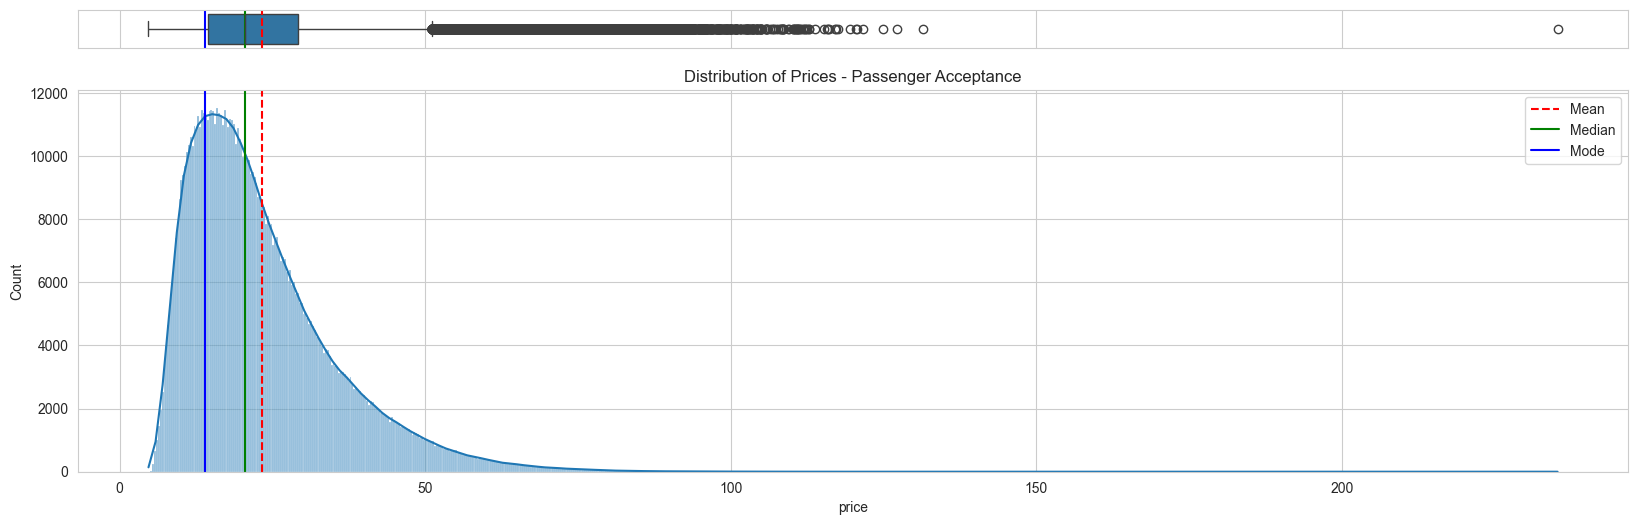

In [15]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.1, 1)}, figsize=(20,6))   

mean = quote_conversion_df['price'].mean()
median = quote_conversion_df['price'].median()
mode = quote_conversion_df['price'].mode().values[0]

sns.boxplot(data=quote_conversion_df, x="price", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=quote_conversion_df, x="price", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")

ax_hist.legend()

ax_box.set(xlabel='')
plt.title("Distribution of Prices - Passenger Acceptance")
plt.show()

In [16]:
acceptance_rate = quote_conversion_df['converted'].mean()
print(f'Overall Passenger Acceptance Rate: {acceptance_rate:.2%}')

Overall Passenger Acceptance Rate: 13.56%


In [17]:
date_features = ['day', 'hour', 'day_of_week']
conversion_rate_by_date = quote_conversion_df.groupby(date_features)['converted'].mean().reset_index()

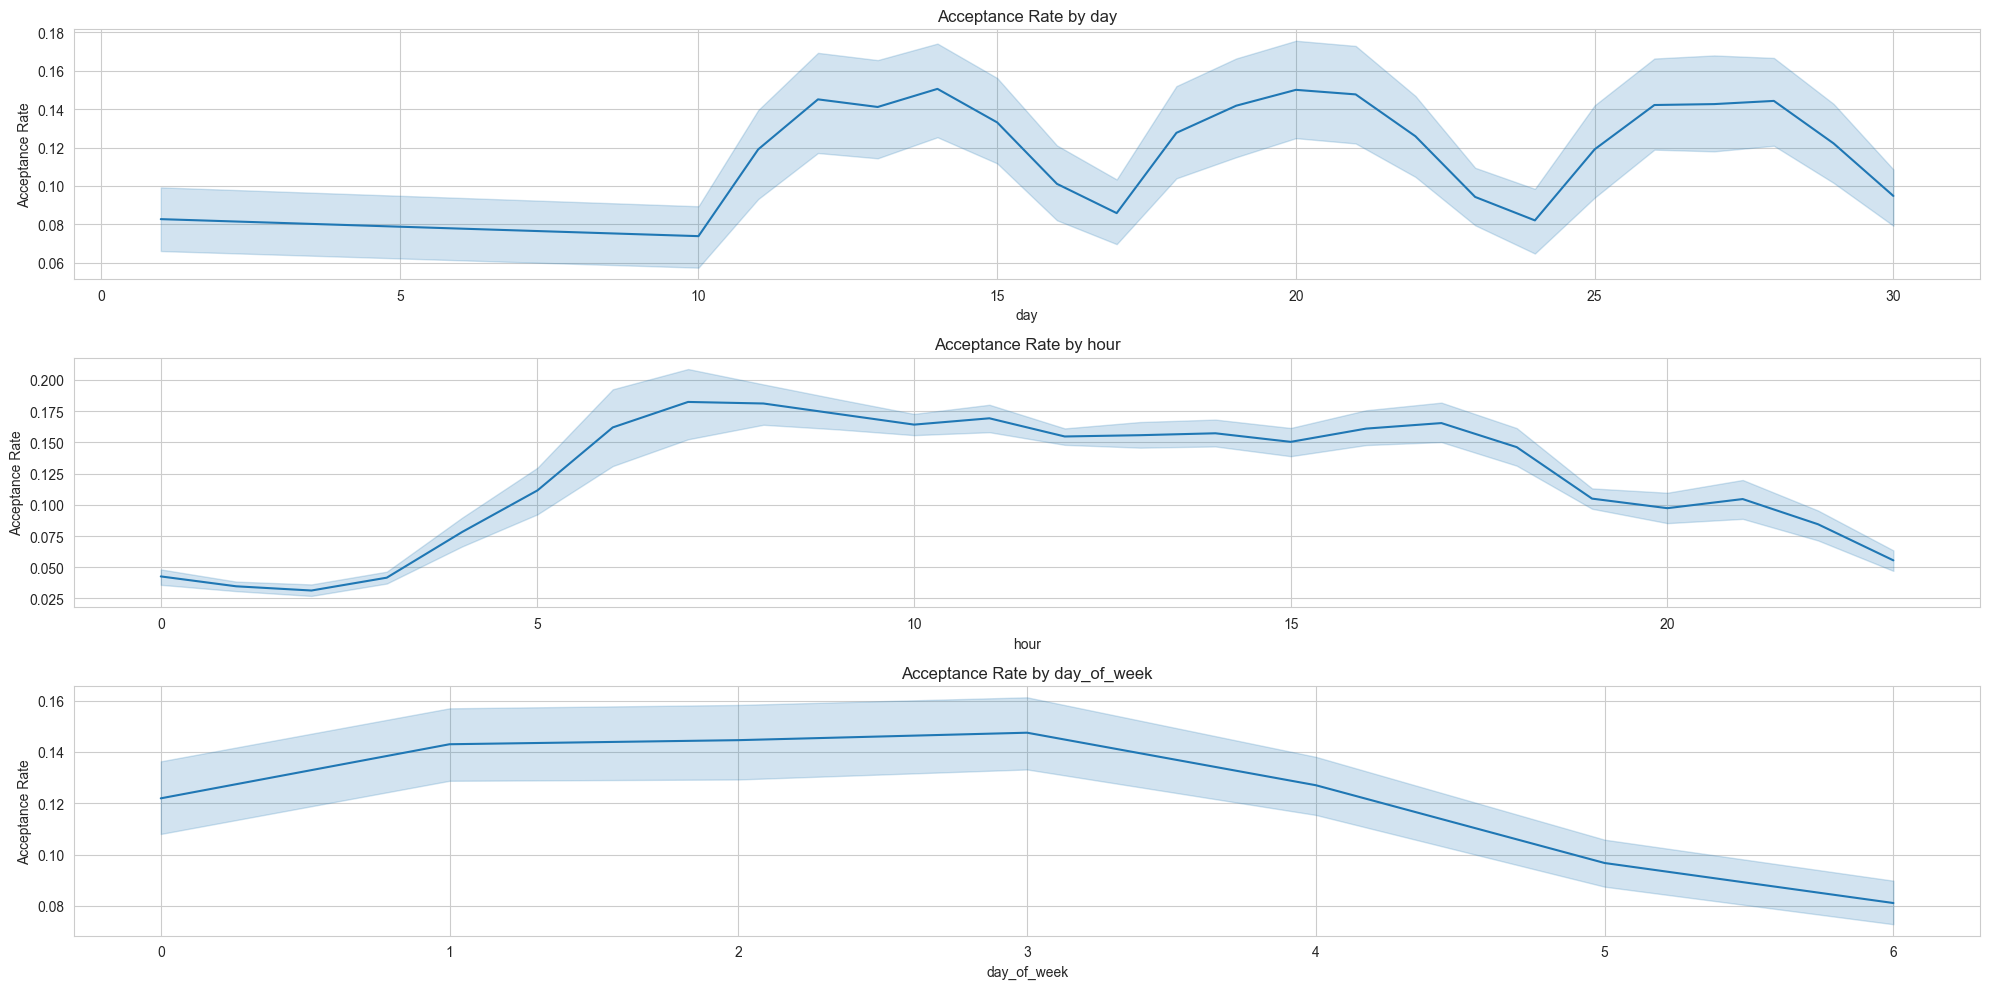

In [18]:
plt.figure(figsize=(20, 10))
for i, feature in enumerate(date_features, 1):
    plt.subplot(3, 1, i)
    sns.lineplot(x=feature, y='converted', data=conversion_rate_by_date)
    plt.title(f'Acceptance Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Acceptance Rate')
plt.tight_layout()
plt.show()

In [19]:
price_bins = pd.cut(quote_conversion_df['price'], bins=np.arange(0, quote_conversion_df['price'].max() + 1, 10))
route_distance_bins = pd.cut(quote_conversion_df['route_distance'], bins=np.arange(0, quote_conversion_df['route_distance'].max() + 1, 1000))
route_duration_bins = pd.cut(quote_conversion_df['route_duration'], bins=np.arange(0, quote_conversion_df['route_duration'].max() + 1, 500))

acceptance_rate_by_price = quote_conversion_df.groupby(price_bins)['converted'].mean()
acceptance_rate_by_eta = quote_conversion_df.groupby(['eta'])['converted'].mean()
acceptance_rate_by_route_distance = quote_conversion_df.groupby(route_distance_bins)['converted'].mean()
acceptance_rate_by_route_duration = quote_conversion_df.groupby(route_duration_bins)['converted'].mean()

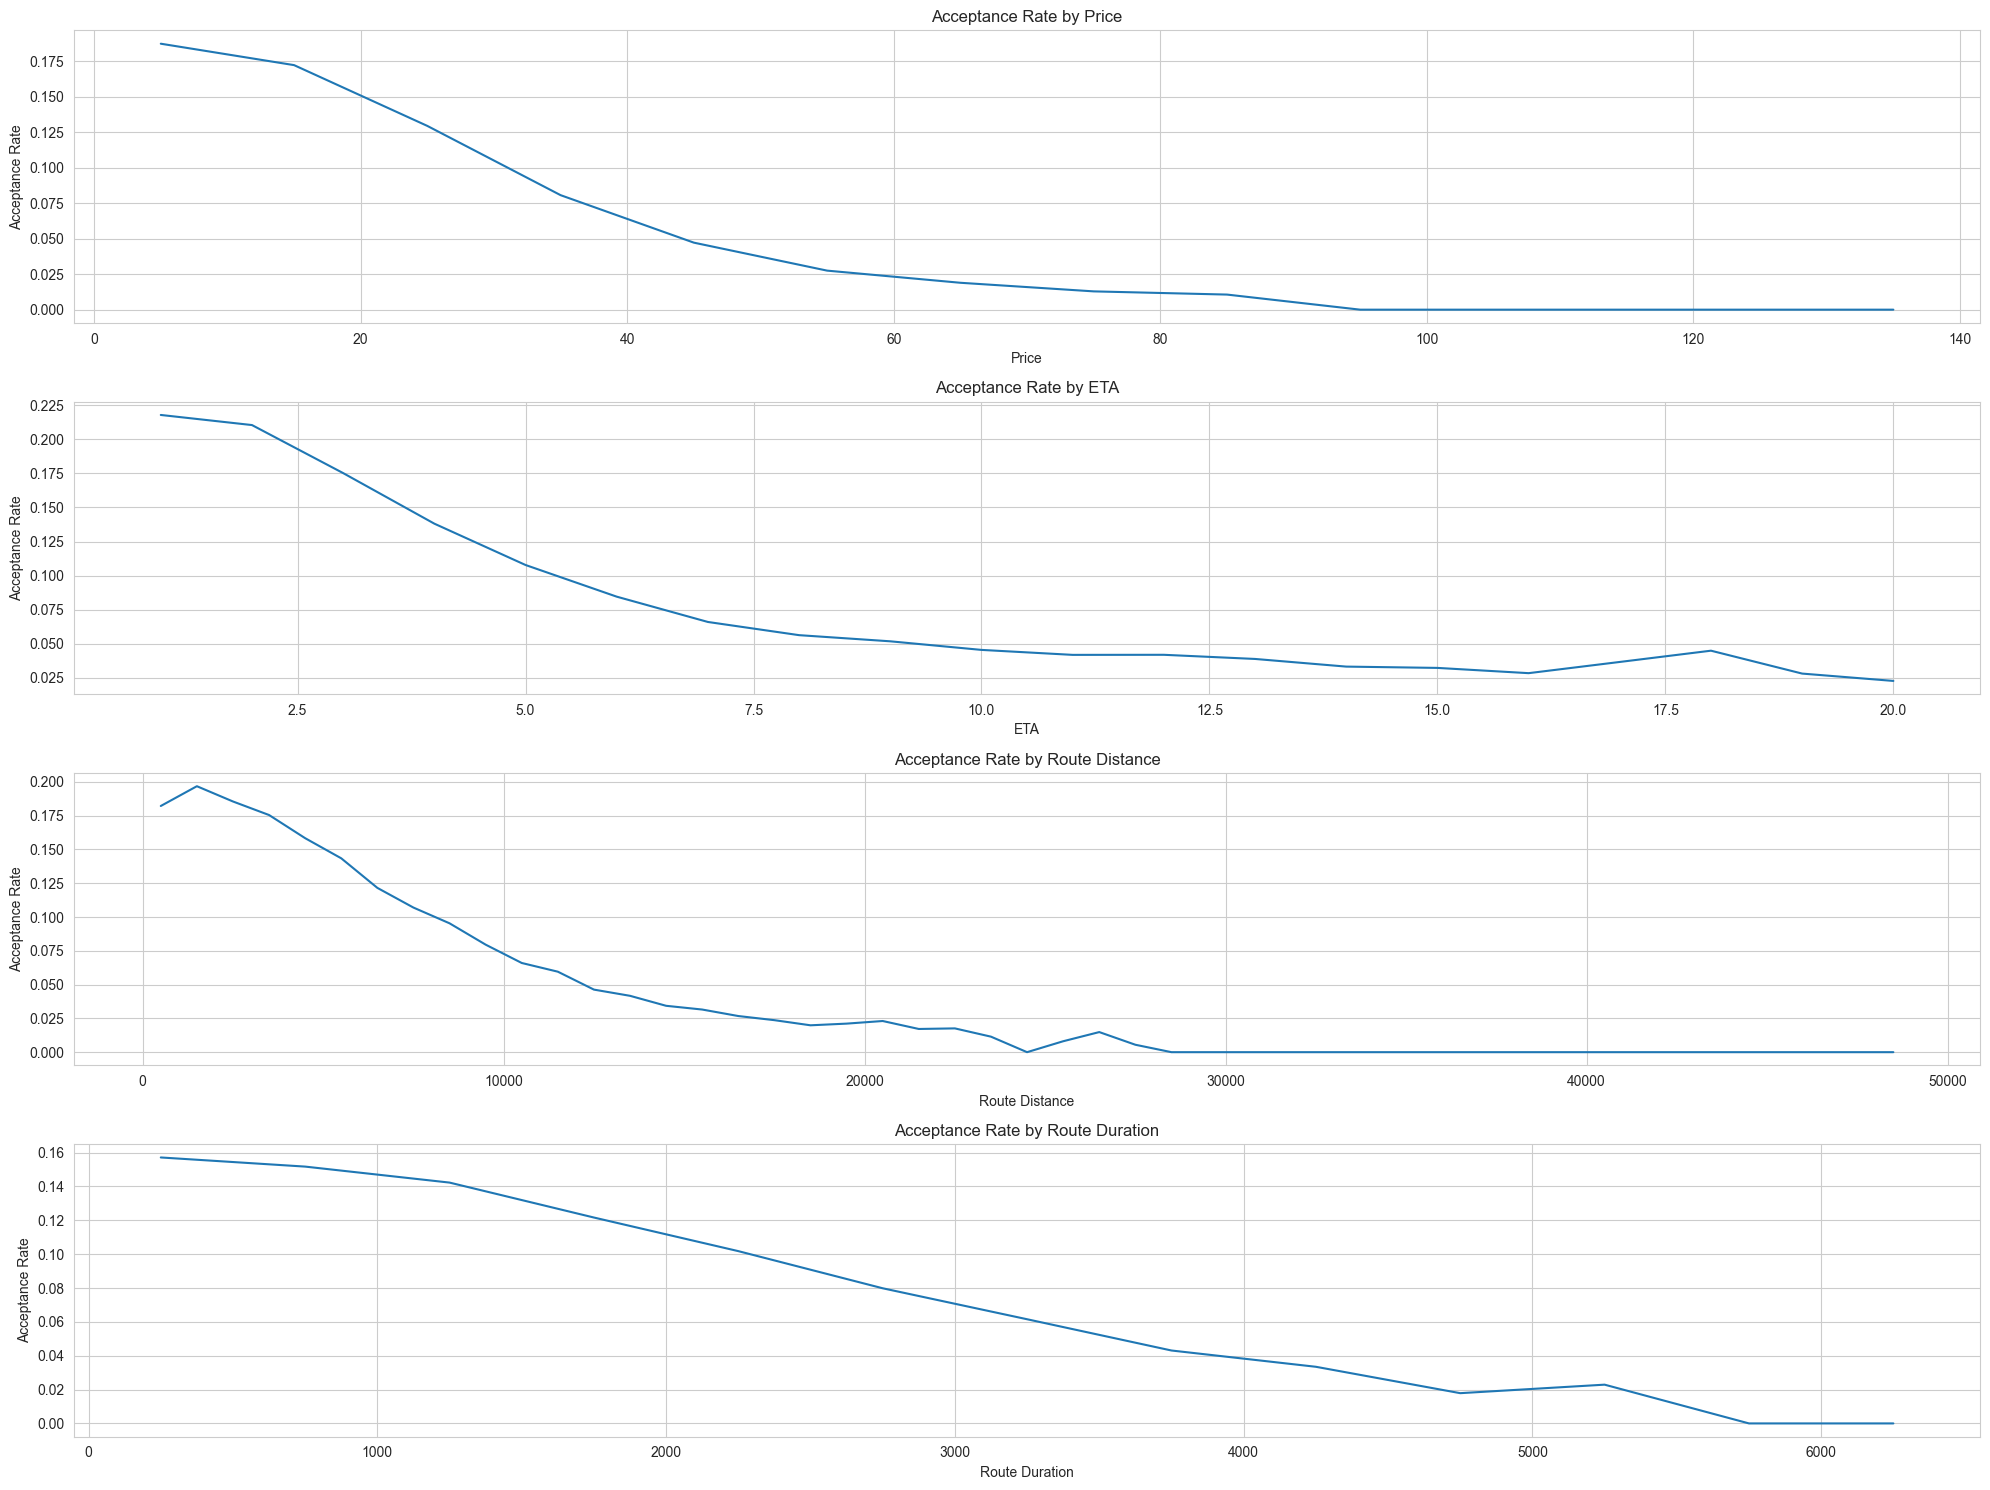

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15)) 

sns.lineplot(x=acceptance_rate_by_price.index.categories.mid, y=acceptance_rate_by_price.values, ax=ax[0])
ax[0].set_title('Acceptance Rate by Price')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_eta.index, y=acceptance_rate_by_eta.values, ax=ax[1])
ax[1].set_title('Acceptance Rate by ETA')
ax[1].set_xlabel('ETA')
ax[1].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_route_distance.index.categories.mid, y=acceptance_rate_by_route_distance.values, ax=ax[2])
ax[2].set_title('Acceptance Rate by Route Distance')
ax[2].set_xlabel('Route Distance')
ax[2].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_route_duration.index.categories.mid, y=acceptance_rate_by_route_duration.values, ax=ax[3])
ax[3].set_title('Acceptance Rate by Route Duration')
ax[3].set_xlabel('Route Duration')
ax[3].set_ylabel('Acceptance Rate')

plt.tight_layout()
plt.show()

In [21]:
route_counts = quote_conversion_df.groupby(['source_h3', 'destination_h3']).size().reset_index(name='counts')
route_counts = route_counts.sort_values(by='counts', ascending=False)

In [22]:
route_counts['geometry'] = route_counts.apply(create_linestring, axis=1)

routes_gdf = gpd.GeoDataFrame(route_counts, geometry='geometry', crs="EPSG:4326")

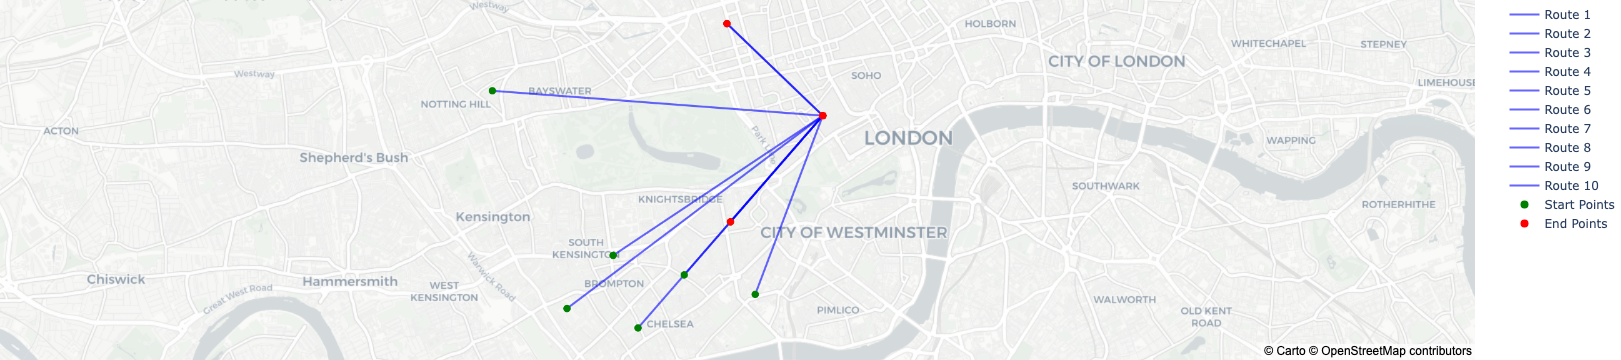

In [23]:
top = 10
create_route_map(routes_gdf[:top])

#### Modelling

In [24]:
X_passenger = quote_conversion_df[['price', 'eta', 'route_distance', 'route_duration', 'source_h3', 'destination_h3', 
                                   'month', 'day', 'hour', 'day_of_week', 'part_of_day']]
y_passenger = quote_conversion_df['converted']

In [25]:
for col in X_passenger.select_dtypes(include=['object', 'category']).columns:
        X_passenger[col] = X_passenger[col].astype('category').cat.codes

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_passenger, y_passenger, test_size=0.33, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [27]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'is_unbalance': True
}

passenger_model = lgb.train(params, train_data, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 78853, number of negative: 503469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 582322, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135411 -> initscore=-1.853937
[LightGBM] [Info] Start training from score -1.853937


In [28]:
y_prob = passenger_model.predict(X_test, num_iteration=passenger_model.best_iteration)
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_prob)}')

              precision    recall  f1-score   support

           0       0.95      0.65      0.77    247844
           1       0.26      0.78      0.39     38972

    accuracy                           0.67    286816
   macro avg       0.61      0.72      0.58    286816
weighted avg       0.86      0.67      0.72    286816

ROC AUC: 0.7870670245333807


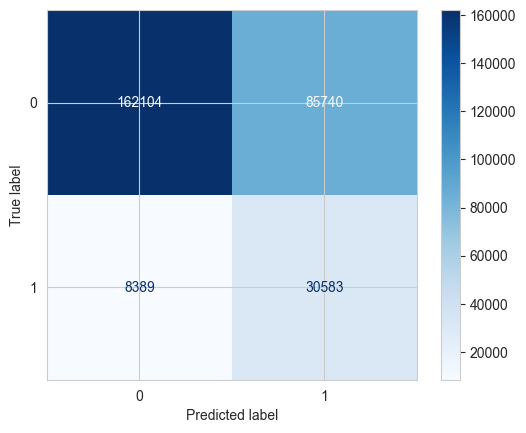

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
explainer = shap.TreeExplainer(passenger_model)
shap_values = explainer.shap_values(X_test)

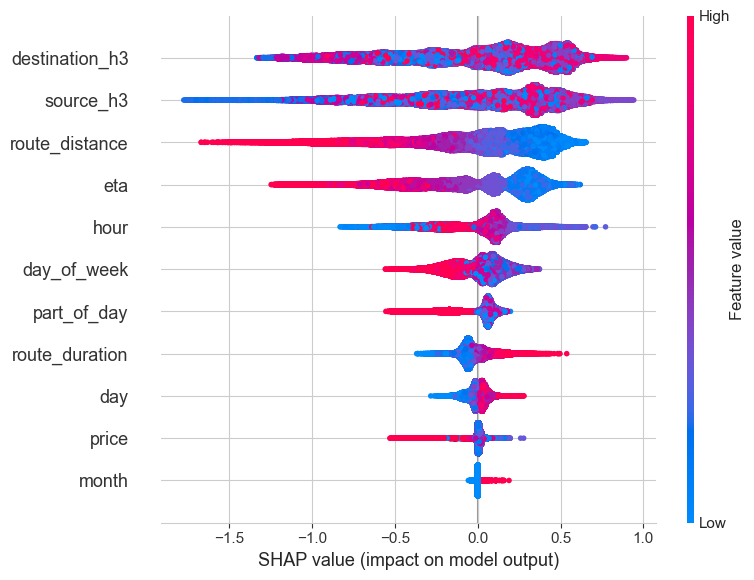

In [31]:
shap.summary_plot(shap_values, X_test)

### Driver Acceptance Model

#### Exploratory Data Analysis

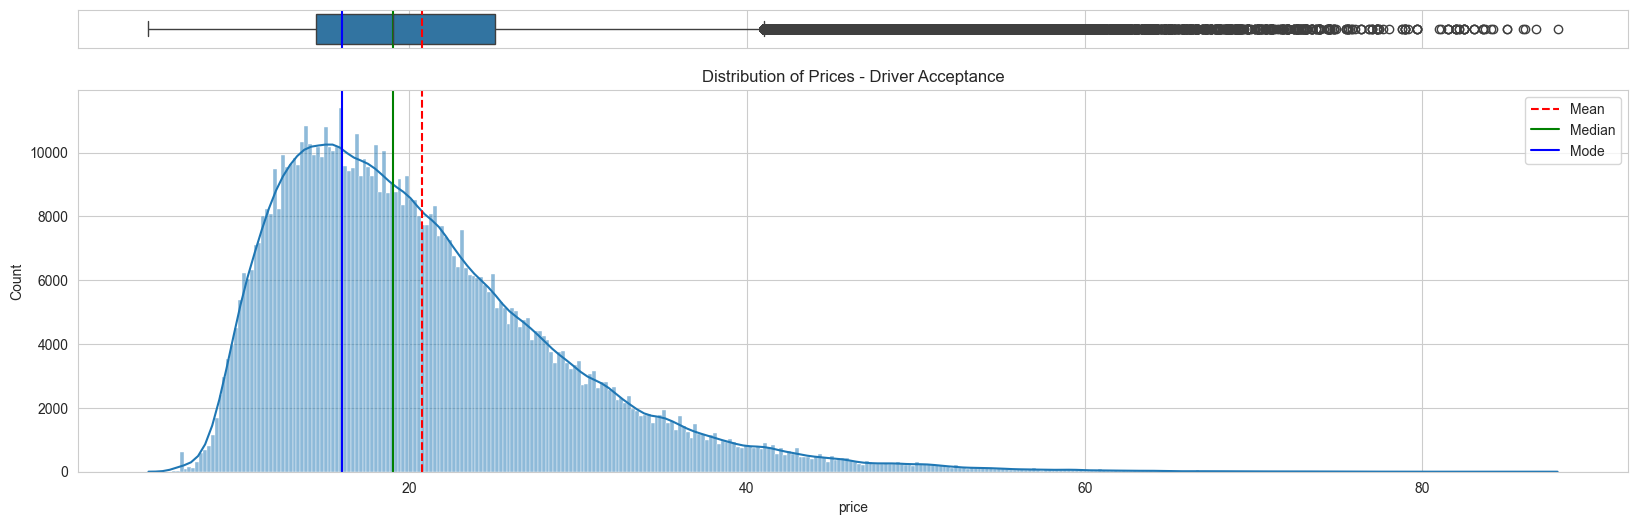

In [32]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.1, 1)}, figsize=(20,6))   

mean = driver_acceptance_df['price'].mean()
median = driver_acceptance_df['price'].median()
mode = driver_acceptance_df['price'].mode().values[0]

sns.boxplot(data=driver_acceptance_df, x="price", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=driver_acceptance_df, x="price", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")

ax_hist.legend()

ax_box.set(xlabel='')
plt.title("Distribution of Prices - Driver Acceptance")
plt.show()

In [33]:
driver_acceptance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 783172 entries, 0 to 783224
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   datetime               783172 non-null  datetime64[ns, UTC]
 1   bookingid              783172 non-null  object             
 2   driverid               783172 non-null  object             
 3   status                 783172 non-null  category           
 4   pickup_duration        783172 non-null  int64              
 5   pickup_distance        783172 non-null  int64              
 6   price                  775974 non-null  float64            
 7   route_distance         783172 non-null  int64              
 8   route_duration         783172 non-null  int64              
 9   source_latitude        783172 non-null  float64            
 10  source_longitude       783172 non-null  float64            
 11  destination_latitude   783172 non-null  floa

In [34]:
driver_acceptance_df.pickup_distance.mean()

1739.3992303095615

In [35]:
driver_acceptance_df["status"] = driver_acceptance_df['status'].apply(lambda x: 1 if x == 'DRIVER_ACCEPT' else 0)
driver_acceptance_df["status"] = driver_acceptance_df["status"].astype(int)

In [36]:
acceptance_rate = driver_acceptance_df['status'].mean()
print(f'Overall Driver Acceptance Rate: {acceptance_rate:.2%}')

Overall Driver Acceptance Rate: 16.21%


In [37]:
date_features = ['day', 'hour', 'day_of_week']
conversion_rate_by_date = driver_acceptance_df.groupby(date_features)['status'].mean().reset_index()

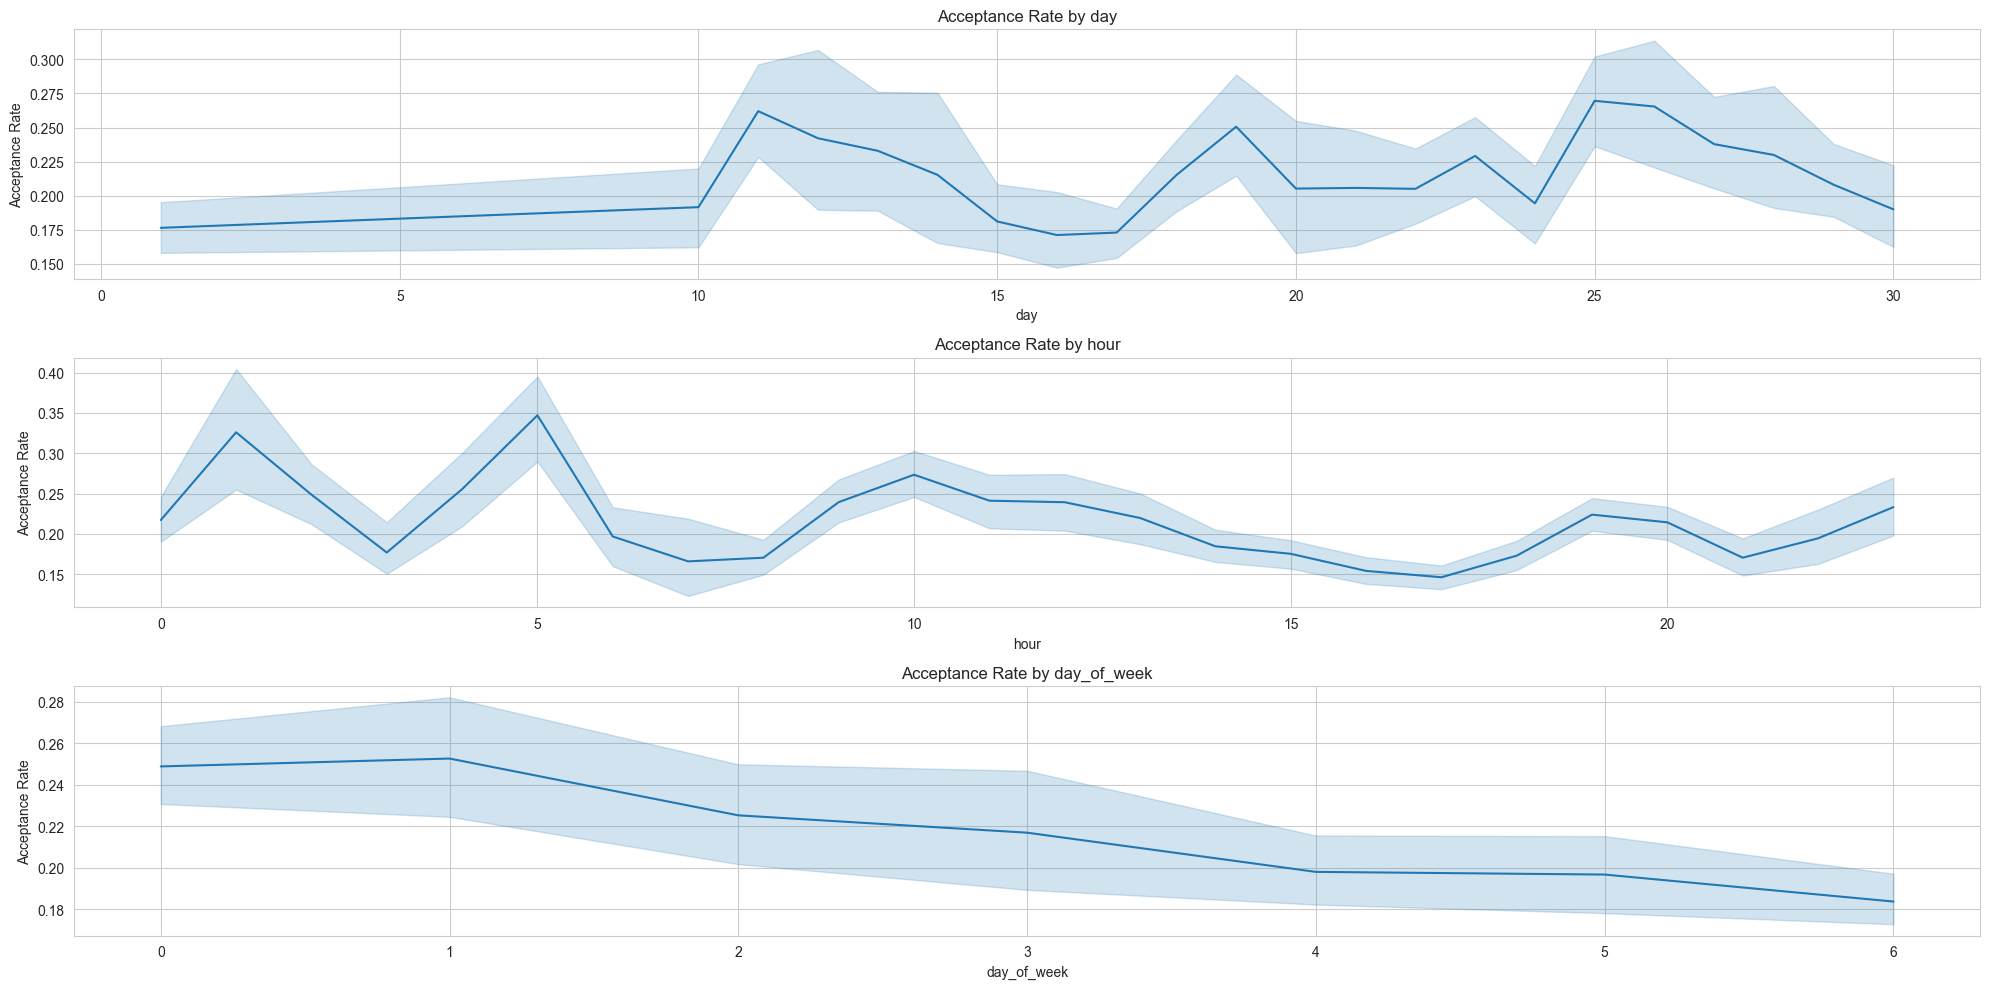

In [38]:
plt.figure(figsize=(20, 10))
for i, feature in enumerate(date_features, 1):
    plt.subplot(3, 1, i)
    sns.lineplot(x=feature, y='status', data=conversion_rate_by_date)
    plt.title(f'Acceptance Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Acceptance Rate')
plt.tight_layout()
plt.show()

In [39]:
driver_acceptance_df.head()

datetime                         bookingid  \
0 2023-09-10 01:01:12.741000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
1 2023-09-10 01:01:28.064000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
2 2023-09-10 01:01:33.302000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
3 2023-09-10 01:02:04.143000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
4 2023-09-10 01:02:38.354000+00:00  ec4bf237bbfddbd9722450b95eb28f33   

                           driverid  status  pickup_duration  pickup_distance  \
0  43d3ebe78c04aef7bafe5cf26fa53563       0              107              375   
1  a25fb994702b734b157d6de98c87881d       0              142              522   
2  e2ef11b3360b0f59fa454bdf18e9376c       0              137              569   
3  2873bd03f370d0461fe86e4b20b4d7f0       0              204              914   
4  b9ee06b6118449ed31d7d1e105d4e538       0              303             1925   

   price  route_distance  route_duration  source_latitude  source_longitude  \
0  23.41            4476             676        51.509333         -0.146257   
1  23.41            4476             676        51.509333         -0.146257   
2  23.41            4476             676        51.509333         -0.146257   
3  23.41            4476             676        51.509333         -0.146257   
4  23.41            4476             676        51.509333         -0.146257   

   destination_latitude  destination_longitude  month  day  hour  day_of_week  \
0             51.490041              -0.122111      9   10     1            6   
1             51.490041              -0.122111      9   10     1            6   
2             51.490041              -0.122111      9   10     1            6   
3             51.490041              -0.122111      9   10     1            6   
4             51.490041              -0.122111      9   10     1            6   

  part_of_day        source_h3   destination_h3  
0       night  88195da491fffff  88194ad141fffff  
1       night  88195da491fffff  88194ad141fffff  
2       night  88195da491fffff  88194ad141fffff  
3       night  88195da491fffff  88194ad141fffff  
4       night  88195da491fffff  88194ad141fffff

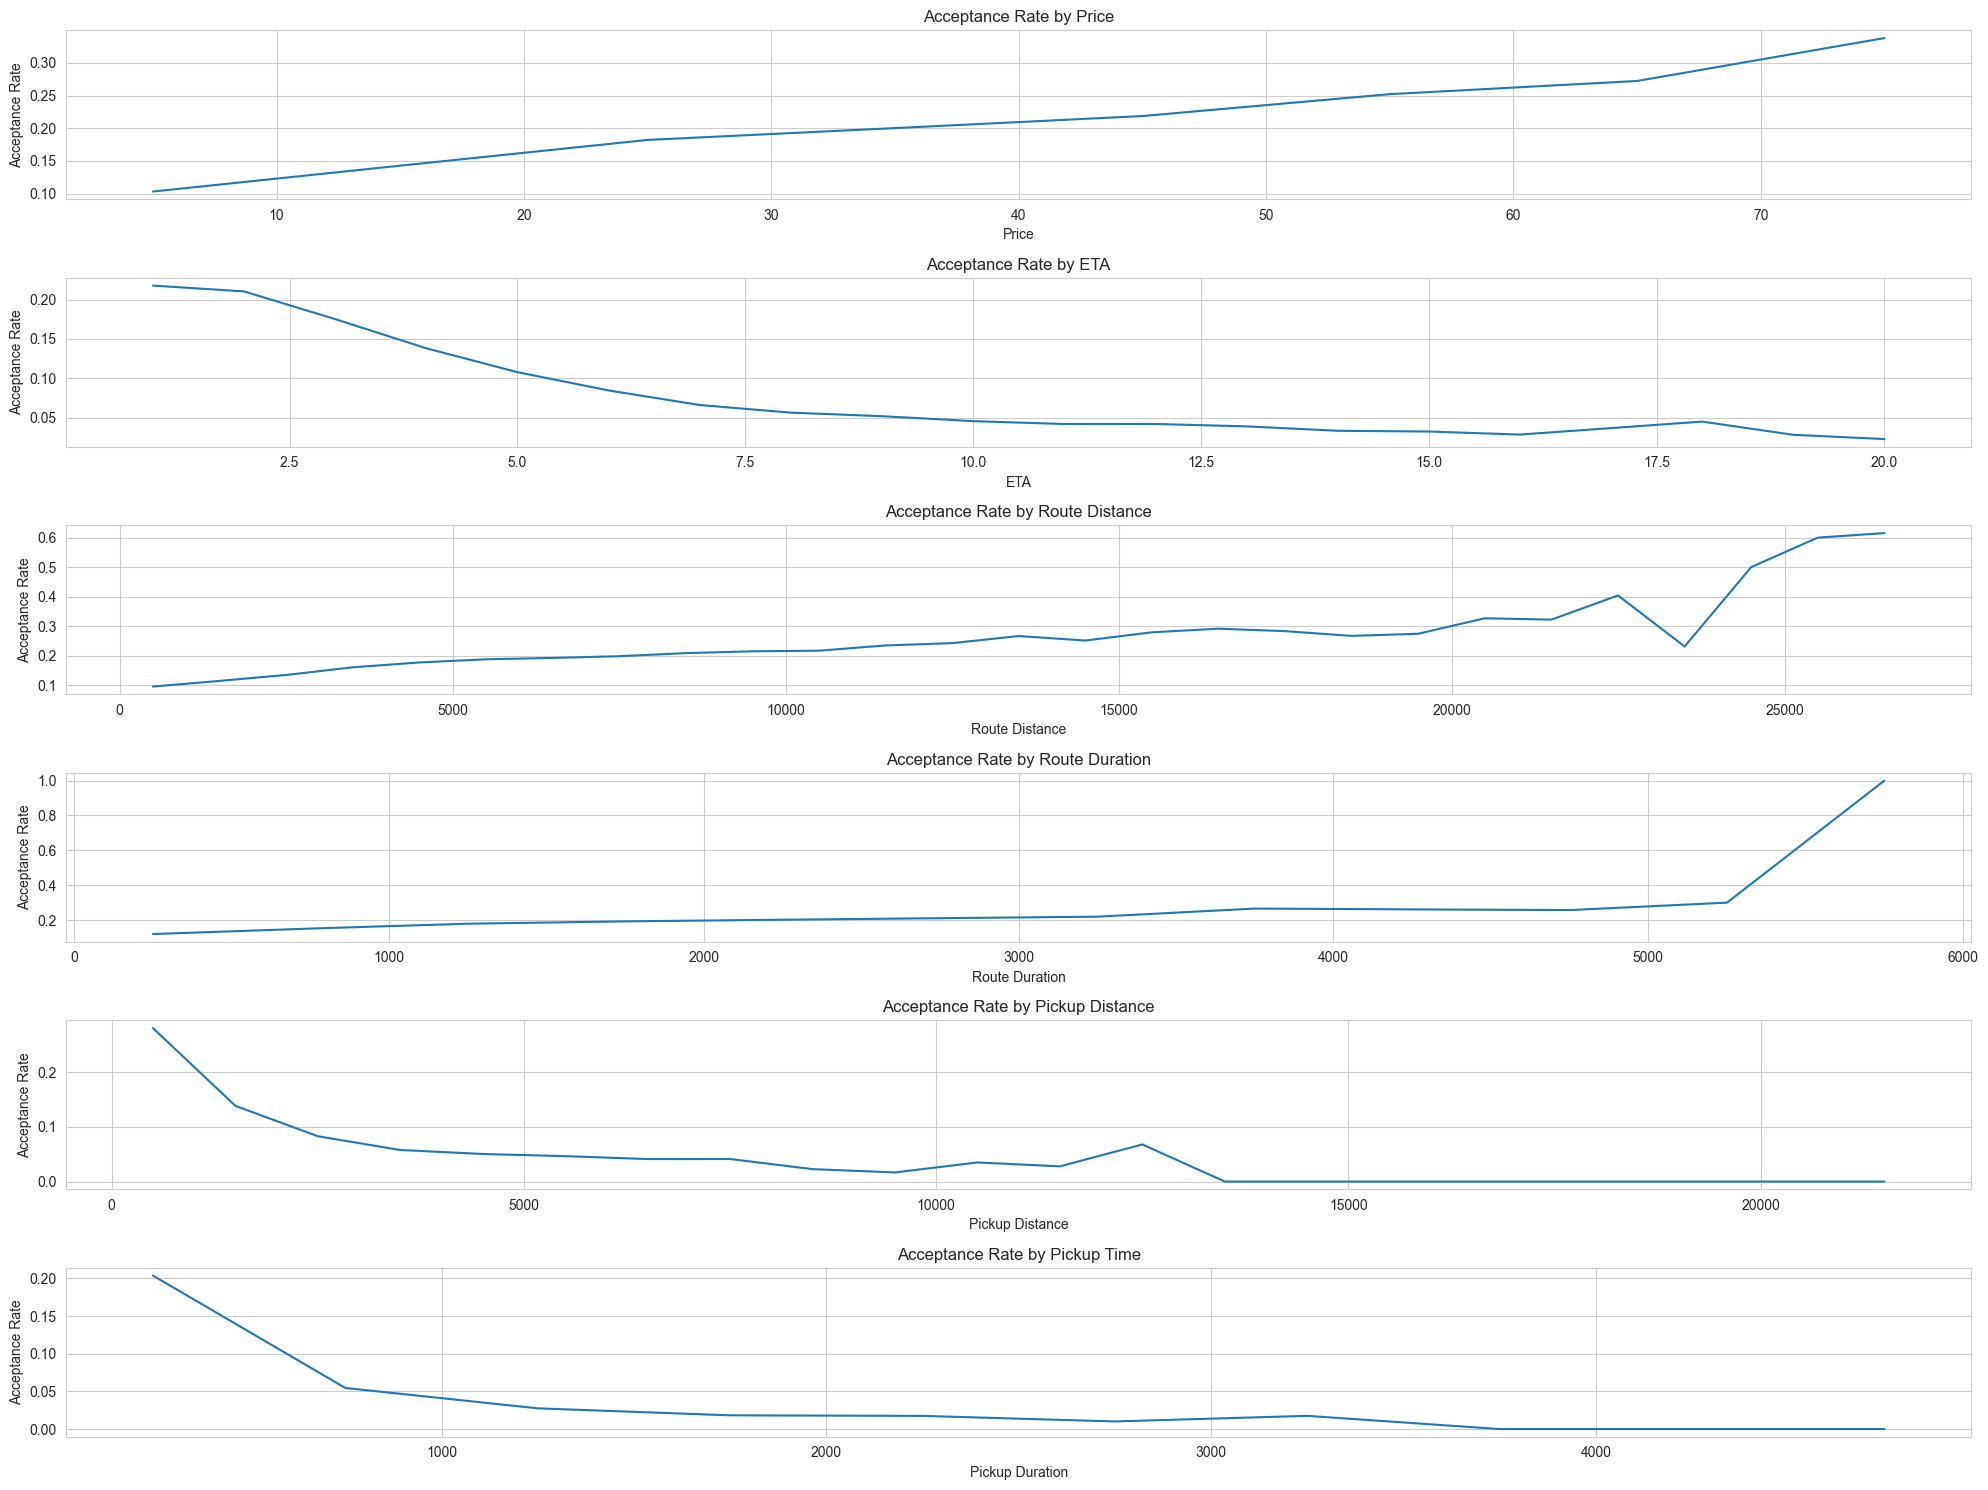

In [40]:
price_bins = pd.cut(driver_acceptance_df['price'], bins=np.arange(0, driver_acceptance_df['price'].max() + 1, 10))
route_distance_bins = pd.cut(driver_acceptance_df['route_distance'], bins=np.arange(0, driver_acceptance_df['route_distance'].max() + 1, 1000))
route_duration_bins = pd.cut(driver_acceptance_df['route_duration'], bins=np.arange(0, driver_acceptance_df['route_duration'].max() + 1, 500))
pickup_distance_bins = pd.cut(driver_acceptance_df['pickup_distance'], bins=np.arange(0, driver_acceptance_df['route_distance'].max() + 1, 1000))
pickup_duration_bins = pd.cut(driver_acceptance_df['pickup_duration'], bins=np.arange(0, driver_acceptance_df['route_distance'].max() + 1, 500))


acceptance_rate_by_price = driver_acceptance_df.groupby(price_bins)['status'].mean()
acceptance_rate_by_route_distance = driver_acceptance_df.groupby(route_distance_bins)['status'].mean()
acceptance_rate_by_route_duration = driver_acceptance_df.groupby(route_duration_bins)['status'].mean()
acceptance_rate_by_pickup_distance = driver_acceptance_df.groupby(pickup_distance_bins)['status'].mean()
acceptance_rate_by_pickup_time = driver_acceptance_df.groupby(pickup_duration_bins)['status'].mean()


fig, ax = plt.subplots(6, 1, figsize=(20, 15)) 

sns.lineplot(x=acceptance_rate_by_price.index.categories.mid, y=acceptance_rate_by_price.values, ax=ax[0])
ax[0].set_title('Acceptance Rate by Price')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_eta.index, y=acceptance_rate_by_eta.values, ax=ax[1])
ax[1].set_title('Acceptance Rate by ETA')
ax[1].set_xlabel('ETA')
ax[1].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_route_distance.index.categories.mid, y=acceptance_rate_by_route_distance.values, ax=ax[2])
ax[2].set_title('Acceptance Rate by Route Distance')
ax[2].set_xlabel('Route Distance')
ax[2].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_route_duration.index.categories.mid, y=acceptance_rate_by_route_duration.values, ax=ax[3])
ax[3].set_title('Acceptance Rate by Route Duration')
ax[3].set_xlabel('Route Duration')
ax[3].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_pickup_distance.index.categories.mid, y=acceptance_rate_by_pickup_distance.values, ax=ax[4])
ax[4].set_title('Acceptance Rate by Pickup Distance')
ax[4].set_xlabel('Pickup Distance')
ax[4].set_ylabel('Acceptance Rate')

sns.lineplot(x=acceptance_rate_by_pickup_time.index.categories.mid, y=acceptance_rate_by_pickup_time.values, ax=ax[5])
ax[5].set_title('Acceptance Rate by Pickup Time')
ax[5].set_xlabel('Pickup Duration')
ax[5].set_ylabel('Acceptance Rate')

plt.tight_layout()
plt.show()

In [41]:
route_counts = driver_acceptance_df.groupby(['source_h3', 'destination_h3']).size().reset_index(name='counts')
route_counts = route_counts.sort_values(by='counts', ascending=False)

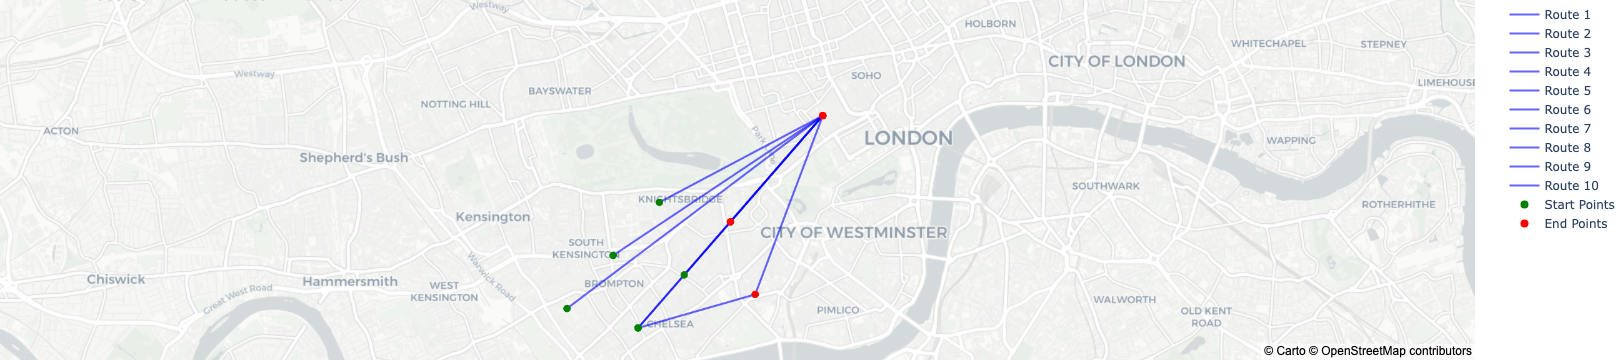

In [42]:
route_counts['geometry'] = route_counts.apply(create_linestring, axis=1)

routes_gdf = gpd.GeoDataFrame(route_counts, geometry='geometry', crs="EPSG:4326")

top = 10
create_route_map(routes_gdf[:top])

#### Modelling

In [43]:
driver_acceptance_df['source_h3'] = driver_acceptance_df['source_h3'].astype('category').cat.codes
driver_acceptance_df['destination_h3'] = driver_acceptance_df['destination_h3'].astype('category').cat.codes

In [44]:
driver_acceptance_df.head()

datetime                         bookingid  \
0 2023-09-10 01:01:12.741000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
1 2023-09-10 01:01:28.064000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
2 2023-09-10 01:01:33.302000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
3 2023-09-10 01:02:04.143000+00:00  ec4bf237bbfddbd9722450b95eb28f33   
4 2023-09-10 01:02:38.354000+00:00  ec4bf237bbfddbd9722450b95eb28f33   

                           driverid  status  pickup_duration  pickup_distance  \
0  43d3ebe78c04aef7bafe5cf26fa53563       0              107              375   
1  a25fb994702b734b157d6de98c87881d       0              142              522   
2  e2ef11b3360b0f59fa454bdf18e9376c       0              137              569   
3  2873bd03f370d0461fe86e4b20b4d7f0       0              204              914   
4  b9ee06b6118449ed31d7d1e105d4e538       0              303             1925   

   price  route_distance  route_duration  source_latitude  source_longitude  \
0  23.41            4476             676        51.509333         -0.146257   
1  23.41            4476             676        51.509333         -0.146257   
2  23.41            4476             676        51.509333         -0.146257   
3  23.41            4476             676        51.509333         -0.146257   
4  23.41            4476             676        51.509333         -0.146257   

   destination_latitude  destination_longitude  month  day  hour  day_of_week  \
0             51.490041              -0.122111      9   10     1            6   
1             51.490041              -0.122111      9   10     1            6   
2             51.490041              -0.122111      9   10     1            6   
3             51.490041              -0.122111      9   10     1            6   
4             51.490041              -0.122111      9   10     1            6   

  part_of_day  source_h3  destination_h3  
0       night        521              80  
1       night        521              80  
2       night        521              80  
3       night        521              80  
4       night        521              80

In [45]:
X_driver = driver_acceptance_df[['price', 'pickup_duration', 'pickup_distance', 'route_distance', 'route_duration', 
                                 'source_h3', 'destination_h3', 'month', 'day', 'hour', 'day_of_week', 'part_of_day']]

y_driver = driver_acceptance_df['status']

In [46]:
for col in X_driver.select_dtypes(include=['object', 'category']).columns:
        X_driver[col] = X_driver[col].astype('category').cat.codes

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_driver, y_driver, test_size=0.33, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [48]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'is_unbalance': True
}

driver_model = lgb.train(params, train_data, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 84819, number of negative: 439906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 524725, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161645 -> initscore=-1.646041
[LightGBM] [Info] Start training from score -1.646041


In [49]:
y_prob = driver_model.predict(X_test, num_iteration=driver_model.best_iteration)
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_prob)}')

              precision    recall  f1-score   support

           0       0.93      0.69      0.79    216309
           1       0.31      0.74      0.44     42138

    accuracy                           0.69    258447
   macro avg       0.62      0.71      0.61    258447
weighted avg       0.83      0.69      0.73    258447

ROC AUC: 0.779969037019665


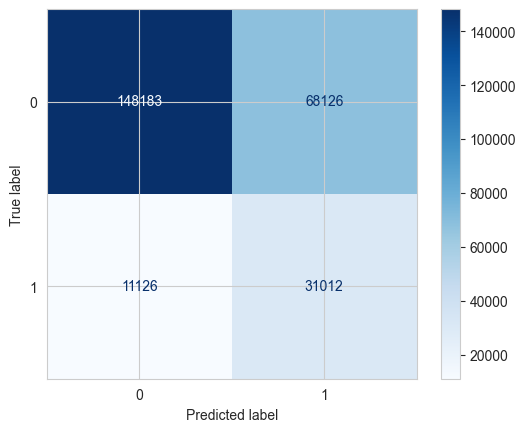

In [50]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [51]:
explainer = shap.TreeExplainer(driver_model)
shap_values = explainer.shap_values(X_test)

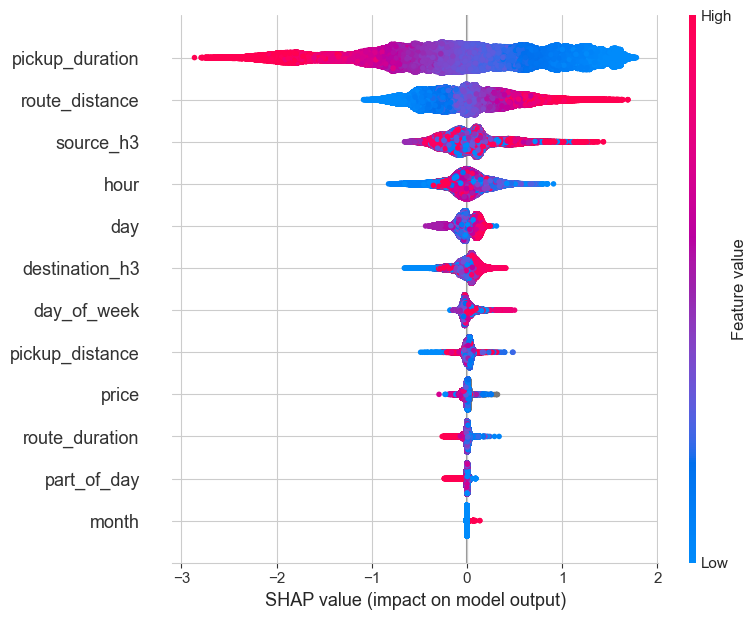

In [52]:
shap.summary_plot(shap_values, X_test)

### Sensitivity Analysis

In [46]:
prices = np.linspace(X_passenger['price'].min(), X_passenger['price'].max(), 100)

passenger_acceptance_probs = [passenger_model.predict(X_passenger.assign(price=price), num_iteration=passenger_model.best_iteration).mean() for price in prices]
driver_acceptance_probs = [driver_model.predict(X_driver.assign(price=price), num_iteration=driver_model.best_iteration).mean() for price in prices]

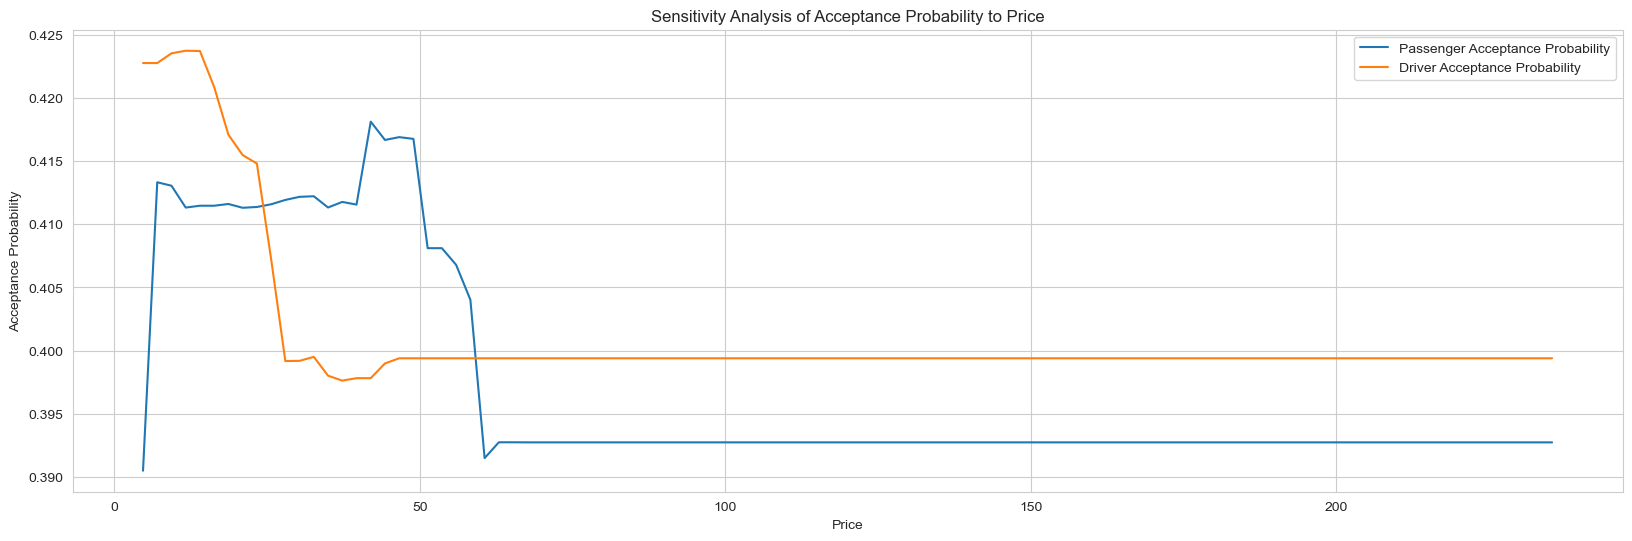

In [47]:
plt.figure(figsize=(20, 6))
plt.plot(prices, passenger_acceptance_probs, label='Passenger Acceptance Probability')
plt.plot(prices, driver_acceptance_probs, label='Driver Acceptance Probability')
plt.xlabel('Price')
plt.ylabel('Acceptance Probability')
plt.title('Sensitivity Analysis of Acceptance Probability to Price')
plt.legend()
plt.show()

In [49]:
passenger_model.save_model('passenger_model.txt', num_iteration=passenger_model.best_iteration) 
driver_model.save_model('driver_model.txt', num_iteration=driver_model.best_iteration) 


In [50]:
test_quotes_df.to_csv("test.csv")

## Part 3
The goal of part 3 is to learn an optimal pricing policy to maximise the total number of completed rides. 

Assume that passenger demand over the course of about a week is what you find in the `DSMarketplaceTHA-TestQuotes.parquet`.

Further assume that you don’t have to worry about driver supply or position. The ETA provided in the dataset is the ETA of the nearest driver.
Create a script to simulate the business process, using your models and a random number generator to simulate the decision points. You will need to provide the price as input for both models. 

Monitor how many of the quotes are made into successful rides.
The task is to find a way to set prices so that the number of successful rides is maximised.

In [48]:
test_quotes_df.head()

datetime  eta  route_distance  route_duration  \
919048  2023-10-02 00:00:01.628  3.0            4255             603   
1074223 2023-10-02 00:00:07.623  3.0           10540            1536   
1194102 2023-10-02 00:00:09.936  4.0            6279             831   
1721900 2023-10-02 00:00:14.402  4.0            2434             426   
1671516 2023-10-02 00:00:16.751  4.0           11591            1368   

         source_latitude  source_longitude  destination_latitude  \
919048         51.498144         -0.195365             51.516676   
1074223        51.519456         -0.116869             51.481013   
1194102        51.491964         -0.194382             51.530327   
1721900        51.531846         -0.125133             51.540288   
1671516        51.454480         -0.107125             51.493184   

         destination_longitude  month  day  hour  day_of_week part_of_day  \
919048               -0.163362     10    2     0            0       night   
1074223              -0.008805     10    2     0            0       night   
1194102              -0.214231     10    2     0            0       night   
1721900              -0.105606     10    2     0            0       night   
1671516               0.009718     10    2     0            0       night   

               source_h3   destination_h3  
919048   88194ada5dfffff  88195da4b9fffff  
1074223  88194ad32dfffff  88194ad231fffff  
1194102  88194ada55fffff  88195da599fffff  
1721900  88195da4d9fffff  88194ad36dfffff  
1671516  88194ad111fffff  88194ad203fffff

# Version 1

In [38]:
test_quotes_df['pickup_duration'] = X_driver['pickup_duration'].mean()
test_quotes_df['pickup_distance'] = X_driver['pickup_distance'].mean()

In [39]:
for col in test_quotes_df.select_dtypes(include=['object', 'category']).columns:
        test_quotes_df[col] = test_quotes_df[col].astype('category').cat.codes

In [40]:
def simulate_rides(test_data, price, passenger_model, driver_model):
    
    successful_rides = 0

    test_data = test_data.copy()
    
    # step 3: generate the quote
    test_data['price'] = price

    for i, row in test_data.iterrows():
        
        passenger_features = row[['price', 'eta', 'route_distance', 'route_duration', 
                                  'source_h3', 'destination_h3', 'month', 'day', 'hour', 
                                  'day_of_week', 'part_of_day']].values.reshape(1, -1)
        
        driver_features = row[['price', 'pickup_duration', 'pickup_distance', 'route_distance', 
                               'route_duration', 'source_h3', 'destination_h3', 'month', 
                               'day', 'hour', 'day_of_week', 'part_of_day']].values.reshape(1, -1)
        
        passenger_prob = passenger_model.predict(passenger_features)[0]
        
        # step 4: passenger decides to convert
        if np.random.rand() < passenger_prob:
            
            driver_prob = driver_model.predict(driver_features)[0]
            
            # step 6: driver accepts the ride
            if np.random.rand() < driver_prob:
                
                successful_rides += 1
    
    return successful_rides

In [41]:
price = 10
successful_rides = simulate_rides(test_quotes_df, price, passenger_model, driver_model)
print(f'Number of successful rides at price {price}: {successful_rides}')

Number of successful rides at price 10: 57243


In [42]:
price_range = np.arange(1, 40, 5)
results = []

for price in price_range:
    successful_rides = simulate_rides(test_quotes_df, price, passenger_model, driver_model)
    results.append((price, successful_rides))
    
results_df = pd.DataFrame(results, columns=['Price', 'Successful Rides'])
results_df.head()

Price  Successful Rides
0      1             54117
1      6             54079
2     11             57028
3     16             56934
4     21             56108

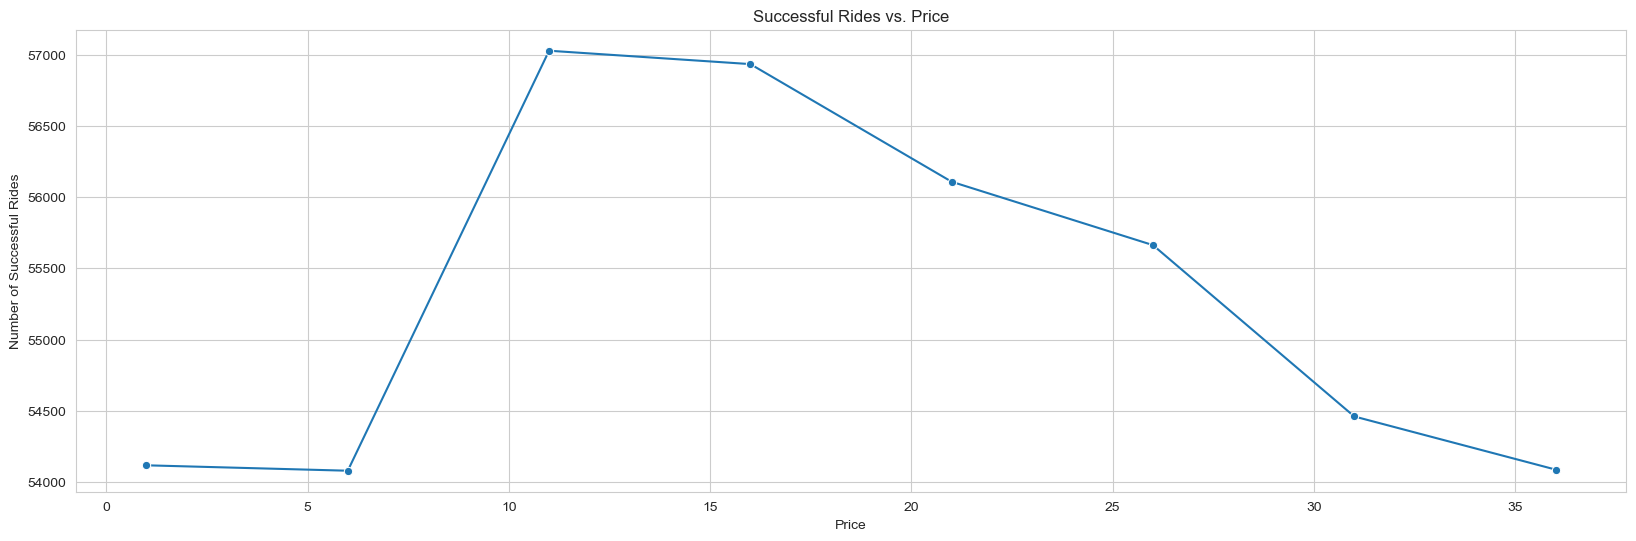

In [43]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=results_df, x='Price', y='Successful Rides', marker='o')
plt.title('Successful Rides vs. Price')
plt.xlabel('Price')
plt.ylabel('Number of Successful Rides')
plt.show()